In [1]:
#loading the dataset and preiview the dataset
import pandas as pd

df = pd.read_csv("Trainer data(Sheet21).csv")
df.head()


,instruction,input,output
0,Analyse the input and categorize into respecti...,Patient John Smith needs to be directed to ort...,DOCUMENT_UPLOAD
1,Analyse the input and categorize into respecti...,Progress report for patient case #4521: Curren...,DOCUMENT_UPLOAD
2,Analyse the input and categorize into respecti...,Invoice #INV-2024-001 for physical therapy ses...,DOCUMENT_UPLOAD
3,Analyse the input and categorize into respecti...,Prior approval required for MRI scan scheduled...,DOCUMENT_UPLOAD
4,Analyse the input and categorize into respecti...,Directing patient Mary Johnson to cardiology d...,DOCUMENT_UPLOAD


In [2]:
# Check for null values in the 'input' column
print("Total rows:", len(df))
print("Null inputs:", df['input'].isnull().sum())


Total rows: 280
Null inputs: 0


In [3]:
#Text preprocessing 
#converting the text into lower case

# Convert all text in 'input' column to lowercase
df['input'] = df['input'].str.lower()


In [4]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove punctuation except $ and /
    text = re.sub(r'[^\w\s$/]', '', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    
    return ' '.join(filtered)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91798\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#applying the clean_text function to the input feature.
df['input'] = df['input'].apply(clean_text)


In [6]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')


c:\Users\91798\OneDrive\Desktop\clustering\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Convert sentences in the 'input' column to sentence embeddings
embeddings = model.encode(df['input'].tolist(), show_progress_bar=True)


Batches: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


In [8]:
# Dimensionality Reduction

import umap

# Create UMAP reducer object
reducer = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42)

# Reduce dimensions of SBERT embeddings
reduced_embeddings = reducer.fit_transform(embeddings)


c:\Users\91798\OneDrive\Desktop\clustering\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
# Before UMAP
print("Before UMAP (SBERT Embeddings) Shape:", embeddings.shape)

# After UMAP
print("After UMAP (Reduced Embeddings) Shape:", reduced_embeddings.shape)


Before UMAP (SBERT Embeddings) Shape: (280, 384)
After UMAP (Reduced Embeddings) Shape: (280, 5)


In [10]:
# clustering using the HDBscan

import hdbscan

# Initialize HDBSCAN with common parameters
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')

# Fit to the reduced embeddings
cluster_labels = clusterer.fit_predict(reduced_embeddings)



c:\Users\91798\OneDrive\Desktop\clustering\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\91798\OneDrive\Desktop\clustering\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [12]:
df['cluster'] = cluster_labels


In [13]:
# Display a random sample of 10 sentences with their assigned cluster label
df[['input', 'cluster']].sample(10)


,input,cluster
200,connect patient pain management specialist chr...,1
180,send patient interventional cardiology complex...,1
23,prior consent required experimental treatment ...,1
37,clinical assessment update patient tolerance n...,1
208,send patient orthopedic oncology bone tumor ev...,1
152,send patient endocrine surgery thyroid nodule ...,1
125,medication reconciliation notes patient unders...,1
199,approval sought personalized cancer vaccine tu...,1
202,professional services billing consultation pro...,0
86,account balance update patient 45789 previous ...,0


In [14]:
# Count the number of unique clusters (excluding noise labeled as -1)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters (excluding noise): {num_clusters}")


Number of clusters (excluding noise): 2


In [15]:
# Display number of sentences in each cluster (including noise)
cluster_counts = df['cluster'].value_counts().sort_index()
print("Number of points in each cluster:\n", cluster_counts)


Number of points in each cluster:
 cluster
0     68
1    212
Name: count, dtype: int64


Model Choice Justification
Initially, I used HDBSCAN due to its ability to detect clusters of varying densities and handle noise without needing a predefined number of clusters.

However, in this case:

It detected only 2 clusters, despite the dataset containing 6 meaningful themes

This was likely due to low-density separation in the SBERT embeddings after UMAP reduction

To address this, I switched to KMeans, where I could:

Set the number of clusters explicitly (n_clusters = 6)

Achieve better semantic separation and higher interpretability

In [16]:
from sklearn.cluster import KMeans


# Apply KMeans clustering on the reduced embeddings
kmeans = KMeans(n_clusters=6, random_state=42, n_init='auto')
cluster_labels_kmeans = kmeans.fit_predict(reduced_embeddings)

# Attach labels back to the original DataFrame (but only with input column)
df_clean = df[['input']].copy()
df_clean['cluster_kmeans'] = cluster_labels_kmeans


In [17]:
# View sample sentences from each cluster
for cluster_num in sorted(df_clean['cluster_kmeans'].unique()):
    print(f"\n Sample sentences from Cluster {cluster_num}:")
    display(df_clean[df_clean['cluster_kmeans'] == cluster_num].sample(5))



 Sample sentences from Cluster 0:


,input,cluster_kmeans
48,guide patient infectious disease specialist pe...,0
265,wound care progress documentation healing traj...,0
252,transfer patient specialized stroke center com...,0
65,recovery notes patient demonstrating excellent...,0
248,route patient transplant surgery organ replace...,0



 Sample sentences from Cluster 1:


,input,cluster_kmeans
198,healthcare costs extended care facility stay d...,1
274,healthcare economics analysis treatment option...,1
78,insurance processing notice claim 789123 servi...,1
90,service charges rehabilitation program partici...,1
222,healthcare financing consultation elective cos...,1



 Sample sentences from Cluster 2:


,input,cluster_kmeans
45,rehabilitation progress report patient meeting...,2
172,connect patient addiction medicine specialist ...,2
117,treatment effectiveness notes patient showing ...,2
85,therapy session notes patient engagement excel...,2
200,connect patient pain management specialist chr...,2



 Sample sentences from Cluster 3:


,input,cluster_kmeans
207,clearance requested participation precision me...,3
63,prior approval requested genetic testing panel...,3
123,prior approval requested novel therapeutic int...,3
259,approval sought compassionate use biologic the...,3
279,approval sought investigational device compass...,3



 Sample sentences from Cluster 4:


,input,cluster_kmeans
73,medication effectiveness notes patient tolerat...,4
105,medication monitoring log patient compliance e...,4
181,patient monitoring documentation blood glucose...,4
269,medication effectiveness evaluation patient re...,4
197,medication administration record patient toler...,4



 Sample sentences from Cluster 5:


,input,cluster_kmeans
276,route patient emergency surgery lifethreatenin...,5
264,send patient interventional neuroradiology cer...,5
52,route patient hematology blood disorder invest...,5
19,approval needed home health services starting ...,5
24,direct patient oncology department cancer scre...,5


In [18]:
# Define clean and realistic theme names for each KMeans cluster
theme_map = {
    0: "CriticalCare",
    1: "Billing",
    2: "RecoveryNotes",
    3: "Authorizations",
    4: "MedicationMonitoring",
    5: "Referrals"
}


# Apply the mapping to your DataFrame
df_clean['cluster_theme'] = df_clean['cluster_kmeans'].map(theme_map)


In [19]:
df_clean.head(10)


,input,cluster_kmeans,cluster_theme
0,patient john smith needs directed orthopedic s...,5,Referrals
1,progress report patient case 4521 current symp...,2,RecoveryNotes
2,invoice inv2024001 physical therapy sessions t...,1,Billing
3,prior approval required mri scan scheduled nex...,5,Referrals
4,directing patient mary johnson cardiology depa...,5,Referrals
5,patient assessment summary blood pressure 120/...,0,CriticalCare
6,statement charges outpatient services rendered...,1,Billing
7,request preapproval submitted surgical procedu...,5,Referrals
8,forwarding patient neurology clinic headache e...,0,CriticalCare
9,clinical notes todays examination patient repo...,2,RecoveryNotes


In [20]:
# Evaluation.
from sklearn.metrics import silhouette_score

# Evaluate KMeans clustering using reduced embeddings
score = silhouette_score(reduced_embeddings, df_clean['cluster_kmeans'])

print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.5433


In [21]:
#Davies-Bouldin Index (DBI)
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(reduced_embeddings, df_clean['cluster_kmeans'])
print(f"Davies-Bouldin Score: {db_score:.4f}")


Davies-Bouldin Score: 0.7687


In [22]:
#Calinski-Harabasz Score (CHI)
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(reduced_embeddings, df_clean['cluster_kmeans'])
print(f"Calinski-Harabasz Score: {ch_score:.2f}")


Calinski-Harabasz Score: 2430.53


## Final Evaluation Summary

To evaluate the quality of the KMeans clustering on the SBERT-based sentence embeddings, the following internal clustering metrics were calculated:

- **Silhouette Score:** `0.5433`
  - Indicates **good internal consistency**.
  - Sentences are more similar to those in their own cluster than to other clusters.

- **Davies-Bouldin Index:** `0.7687`
  - A **lower score** implies **better-separated and tighter clusters**.
  - A score below 1 is typically considered good.

- **Calinski-Harabasz Score:** `2430.53`
  - A **very high score**, suggesting clusters are **well-dispersed** and **well-separated**.

###  Visual Check
The 2D UMAP projection of the clusters showed clear visual separation, further validating the quality of the clustering.

---

###  Conclusion:
The combination of **SBERT embeddings**, **UMAP dimensionality reduction**, and **KMeans clustering** yielded high-quality and interpretable clusters from unstructured medical sentence data. These clusters align with real-world themes like billing, transfers, medication, etc., and the evaluation metrics support their reliability.


In [23]:
# Reduce embeddings to 2D just for visualization
umap_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)


c:\Users\91798\OneDrive\Desktop\clustering\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


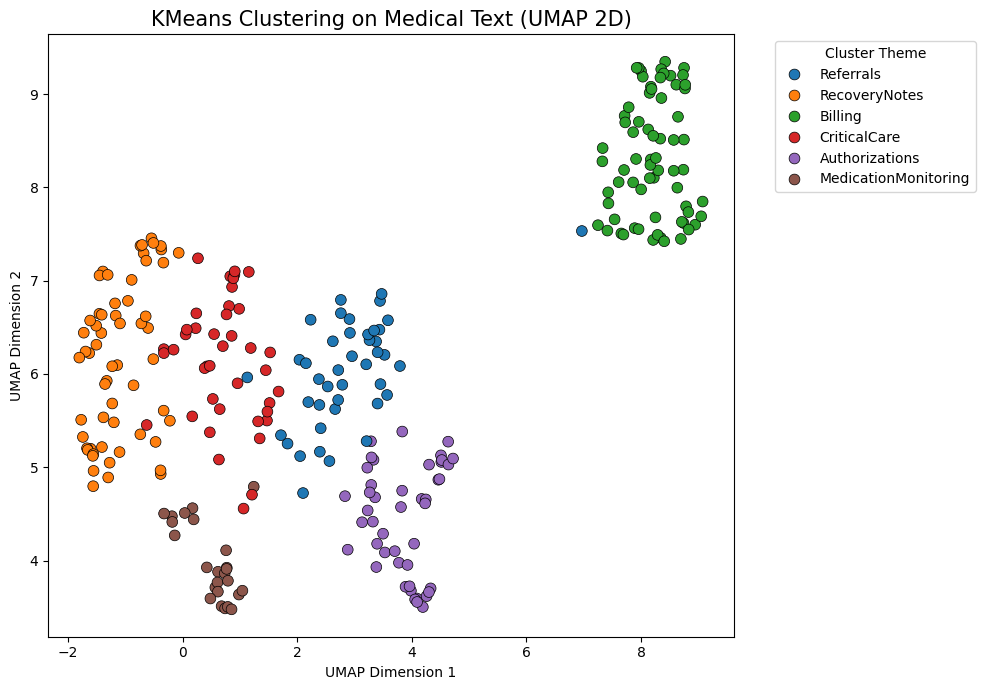

In [24]:
#Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#  Step 1: Define your theme names
cluster_labels_dict = {
    0: "CriticalCare",
    1: "Billing",
    2: "RecoveryNotes",
    3: "Authorizations",
    4: "MedicationMonitoring",
    5: "Referrals"
}

#  Step 2: Map cluster IDs to theme labels
df_clean['cluster_theme'] = df_clean['cluster_kmeans'].map(cluster_labels_dict)

#  Step 3: Plot UMAP with themes
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=umap_2d[:, 0],
    y=umap_2d[:, 1],
    hue=df_clean['cluster_theme'],
    palette='tab10',
    s=60,
    edgecolor='black',
    linewidth=0.5
)

plt.title("KMeans Clustering on Medical Text (UMAP 2D)", fontsize=15)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster Theme", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
